## 1. Importeren van benodigde bibliotheken

In deze stap worden alle benodigde bibliotheken ingeladen die essentieel zijn voor het bouwen, trainen en evalueren van een image captioning-model.

We gebruiken:
- huggingface_hub en getpass voor veilige toegang tot modellen en datasets via Hugging Face
- datasets om kant-en-klare image-text datasets zoals H&M Captions in te laden
- torchvision en PIL voor het transformeren en visualiseren van afbeeldingsdata
- transformers om het ViT-GPT2 encoder-decoder model te gebruiken
- torch en DataLoader om met batches te trainen en het model efficiënt te verwerken
- evaluate voor de berekening van evaluatiemetrieken zoals BLEU-score
- tqdm voor een overzichtelijke voortgangsbalk tijdens training
- matplotlib en random voor het tonen en willekeurig selecteren van afbeeldingen

In [ ]:
# Imports
from huggingface_hub import login
import getpass
from datasets import load_dataset
from torchvision import transforms
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
from torch.utils.data import DataLoader
import torch
import evaluate
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import random
import torch

In [6]:
#!pip install transformers datasets evaluate torchvision huggingface_hub --quiet

## 2. Inloggen bij Hugging Face

Om toegang te krijgen tot bepaalde datasets en modellen op het Hugging Face platform is authenticatie vereist. We loggen daarom in met een persoonlijk access token. Het token wordt via getpass ingevoerd zodat het niet zichtbaar is in het notebook. Dit verhoogt de veiligheid, vooral wanneer het notebook gedeeld of opgeslagen wordt in de cloud of in een publieke repository. Zonder deze stap kan het laden van beschermde datasets of modellen mislukken.

In [1]:
# Login zonder token zichtbaar te maken in je notebook
token = getpass.getpass("Voer je Hugging Face access token in: ")
login(token=token)

Voer je Hugging Face access token in: ········


## 3. Laden en splitsen van de H&M Fashion Captions dataset

We laden de dataset 'tomytjandra/h-and-m-fashion-caption-12k' via Hugging Face. Deze dataset bevat meer dan 12.000 afbeeldingen van kledingstukken met bijbehorende Engelstalige productomschrijvingen. Elke afbeelding is gekoppeld aan één tekstuele beschrijving, wat ideaal is voor het trainen van een image captioning-model in een supervised learning setting.

Na het laden splitsen we de dataset in een trainings- en validatieset. Dit doen we met een verhouding van 90% training en 10% validatie, zodat het model geleerd gedrag kan generaliseren naar nieuwe, ongeziene data.

Omdat het trainen van grote datasets in Google Colab kan leiden tot geheugenproblemen, beperken we het aantal trainingsvoorbeelden tot 2000 en het aantal validatievoorbeelden tot 300. Deze reductie maakt het mogelijk om het model efficiënt te trainen en evalueren binnen de beperkingen van de beschikbare hardware, zonder daarbij de representativiteit van de data te verliezen.

In [ ]:
# ChatGPT, 2025, Prompt 1: "Welke eigenschappen maken een image-text dataset geschikt voor supervised captioning? Hoe bepaal ik een evenwichtige split voor train/test en hoe selecteer ik een subset die past binnen GPU-geheugenlimieten zonder bias te introduceren?"
# Link: https://chatgpt.com/share/6857fc75-3d30-8001-9101-ce0db9d523aa

# Gebruik juiste dataset van Hugging Face
dataset = load_dataset("tomytjandra/h-and-m-fashion-caption-12k")

# Split in train/test
dataset = dataset["train"].train_test_split(test_size=0.1)

train_dataset = dataset["train"].select(range(2000))  # maximaal 2000 ivm trainingstijd
val_dataset = dataset["test"].select(range(300))      

## 4. Voorbewerking van afbeeldingsdata

In deze stap definiëren we een transformatiepipeline voor de afbeeldingen zodat ze geschikt zijn als input voor het Vision Transformer model (ViT). Omdat ViT-modellen alleen werken met afbeeldingen van vaste afmetingen, schalen we alle afbeeldingen naar 224 bij 224 pixels.

Daarnaast converteren we elke afbeelding naar een PyTorch-tensor, wat nodig is voor verwerking in het neurale netwerk. Deze stappen zijn verplicht voordat de afbeeldingen als input kunnen worden gebruikt in het encoder-gedeelte van het model. Zonder uniforme grootte en tensorrepresentatie zou het model fouten geven tijdens training of inferentie.

In [ ]:
# ChatGPT, 2025, Prompt 1: "Wat is de invoervereiste qua resolutie en tensorformaat voor ViT-architecturen, en hoe beïnvloeden resizing en normalisatie de performance van visuele encoders? Welke interpolatiemethoden behouden details bij downsampling naar 224x224 pixels?"
# Link: https://chatgpt.com/share/6857fcdf-2fbc-8001-ab19-efdbde61a083
# Transformeer afbeeldingen naar inputgrootte voor model
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

## 5. Laden van het voorgetrainde Vision-Text model

In deze stap laden we een bestaand encoder-decoder model dat ontworpen is voor image captioning: het model vit-gpt2-image-captioning. Dit model combineert een Vision Transformer (ViT) als encoder en een GPT-2 taalmodel als decoder.

De encoder zet de visuele informatie van een afbeelding om in een vectorrepresentatie. Deze representatie wordt vervolgens gebruikt door de decoder om een beschrijvende tekst te genereren. Omdat dit model reeds is voorgetraind op grote datasets met afbeeldings-bijschriftparen, kunnen we het effectief fine-tunen op onze kleinere dataset zonder dat we het model vanaf nul hoeven te trainen. Deze benadering valt onder transfer learning, waarbij eerder verworven kennis van een model wordt toegepast op een nieuwe taak, zoals beschreven door Howard en Ruder (2018).

Daarnaast laden we ook de bijbehorende processor, die de afbeeldingen normaliseert en schaalt voordat ze naar het model gaan, en de tokenizer, die captions omzet naar tokens en omgekeerd.

Bron:
Howard, J., & Ruder, S. (2018). Universal Language Model Fine-tuning for Text Classification. In Proceedings of the 56th Annual Meeting of the Association for Computational Linguistics (pp. 328–339). https://arxiv.org/abs/1801.06146

In [ ]:
# ChatGPT, 2025, Prompt 1: "Hoe werkt de encoder-decoderarchitectuur van VisionEncoderDecoderModel technisch? Welke interne mechanismen gebruiken ViT en GPT-2 voor cross-modal alignment? Wat zijn de implicaties van shared embeddings en layer freezing bij transfer learning in deze configuratie "
# Link: https://chatgpt.com/share/6857fd3c-7318-8001-8e5b-1636a7bd0163
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.48.2"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

## 6. Preprocessing per datapunt

We definiëren een functie die preprocessing uitvoert op elk individueel datapunt uit de dataset. De afbeelding wordt getransformeerd naar een 224x224 tensor met behulp van de eerder gedefinieerde transformaties.

Daarnaast wordt de bijbehorende caption omgezet naar een lijst van tokens met behulp van de tokenizer. De parameter max_length is ingesteld op 32 tokens. Deze waarde is gekozen op basis van verkennend onderzoek: de meeste captions in mode-datasets zijn tussen de 10 en 20 woorden lang. Door iets extra ruimte te laten, vermijden we dat langere captions worden afgekapt, terwijl we toch efficiënt omgaan met padding en rekentijd. Dit sluit aan bij de gemiddelde captionlengtes die zijn waargenomen in het COCO-datasetonderzoek (Lin et al., 2014).

De gegenereerde labels bestaan uit integers die overeenkomen met de tokens in de caption. Deze worden tijdens het trainen vergeleken met de voorspellingen van het model.

Bron:  
Lin, T.-Y., Maire, M., Belongie, S., Hays, J., Perona, P., Ramanan, D., ... & Dollár, P. (2014). Microsoft COCO: Common Objects in Context. *European Conference on Computer Vision (ECCV)*. https://arxiv.org/abs/1405.0312



## 7. Preprocessing toepassen en dataset formatteren

Met de .map()-functie passen we de preprocessing-functie toe op elk datapunt in zowel de trainings- als validatieset. Deze methode zorgt ervoor dat de afbeeldingen en captions automatisch worden omgezet naar het juiste formaat voor modelinput.

Daarna gebruiken we .set_format() om expliciet aan te geven dat we PyTorch-tensors willen gebruiken en welke kolommen daarin nodig zijn. Door de kolommen te beperken tot 'pixel_values' en 'labels' vermijden we onnodige geheugenbelasting, wat cruciaal is bij training op beperkte hardware zoals Google Colab. Deze stap is verplicht om de gegevens correct te kunnen gebruiken in de PyTorch DataLoader in de volgende fase.

In [ ]:
# ChatGPT, 2025, Prompt 1: "Hoe tokeniseer ik captiontekst op een manier die consistent is met de decoder van het model? Hoe verhoudt de keuze van max_length (32 tokens) zich tot de gemiddelde informatiedichtheid van productomschrijvingen in natuurlijke taal? Hoe vertaalt dit zich naar sequentielengte versus padding overhead?"
# ChatGPT, 2025, Prompt 2: "Wat is het voordeel van .map() bij Hugging Face datasets boven for-loops? Hoe behoud ik efficiëntie bij gelijktijdige beeld- en tekstverwerking, en waarom moet ik de dataset herformateren naar een PyTorch-compatibele structuur met gespecificeerde kolommen (zoals pixel_values, labels)?"
# Link: https://chatgpt.com/share/6857fdd3-5518-8001-b6bd-ed3fd9c0cd75

max_length = 32

def preprocess(example):
    image = image_transform(example["image"])
    caption = example["text"]
    labels = tokenizer(caption, padding="max_length", truncation=True, max_length=max_length).input_ids
    return {"pixel_values": image, "labels": labels}

train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)

train_dataset.set_format(type="torch", columns=["pixel_values", "labels"])
val_dataset.set_format(type="torch", columns=["pixel_values", "labels"])

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

## 8. Train en validatie DataLoaders

We gebruiken PyTorch's DataLoader om de voorbewerkte datasets in batches aan het model aan te bieden. Een batchgrootte van 8 is gekozen als een praktische balans tussen rekensnelheid en het beschikbare geheugen in Google Colab. Een te grote batchgrootte kan leiden tot geheugenfouten, terwijl een te kleine batch de training aanzienlijk vertraagt.

De trainingsset wordt geshuffeld om te voorkomen dat het model leert op basis van de volgorde van de data. Door shuffling krijgt het model steeds andere combinaties van voorbeelden te zien, wat overfitting tegengaat en de generalisatie verbetert.

Voor de validatieset wordt geen shuffling toegepast, zodat de evaluatie consistent en reproduceerbaar blijft.

In [ ]:
# ChatGPT, 2025, Prompt 1: "Wat zijn de geheugeneffecten van het kiezen van een bepaalde batch size in een transformer-gebaseerde captioning pipeline?"
# Link: https://chatgpt.com/share/6857fe34-c27c-8001-8e16-29734fede4c4

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

## 9. Instellen van optimizer en device

In deze stap kiezen we de optimizer en bepalen we op welk apparaat het model wordt getraind. We gebruiken de AdamW-optimizer, een variant van Adam met decoupled weight decay. Deze optimizer wordt vaak toegepast bij het trainen van transformer-gebaseerde modellen omdat het betere generalisatieprestaties oplevert dan standaard Adam. De weight decay voorkomt overfitting door gewichten af te straffen die te groot worden.

De learning rate is ingesteld op 5e-5, wat een gangbare waarde is voor het fine-tunen van grote voorgetrainde modellen. Een lagere learning rate voorkomt dat het model abrupt zijn reeds aangeleerde kennis overschrijft, wat belangrijk is bij transfer learning.

Het model wordt naar een GPU gestuurd als deze beschikbaar is. Het gebruik van een GPU zorgt voor veel snellere matrixvermenigvuldigingen en trainingsprocessen dan een CPU, vooral bij grote modellen en datasets.

Bron:  
Loshchilov, I., & Hutter, F. (2019). Decoupled Weight Decay Regularization. *International Conference on Learning Representations (ICLR)*. https://arxiv.org/abs/1711.05101

In [ ]:
# ChatGPT, 2025, Prompt 1:Wat is het effect van weight decay in AdamW op het minimaliseren van loss zonder overfitting? Hoe verschilt decoupled weight decay mathematisch van traditionele L2-regularisatie? Waarom is een learning rate van 5e-5 stabiel bij fine-tuning van modellen met LayerNorm en Attention?
# Link: https://chatgpt.com/share/6857fe7c-9edc-8001-92c7-66a581483367

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(i

## 10. Model trainen en evalueren met BLEU-score

In deze stap trainen we het image captioning-model in meerdere rondes (epochs) en evalueren we het model na elke epoch met behulp van de BLEU-score.

Tijdens training voorspelt het model een reeks woorden (tokens) op basis van de afbeelding. De fout tussen voorspelling en de echte caption wordt gemeten met de CrossEntropyLoss. Deze lossfunctie vergelijkt de gegenereerde tokens met de echte tokens op elke tijdstap.

De formule voor Cross-Entropy Loss is:

![CrossEntropyLoss](https://latex.codecogs.com/png.image?\dpi{150}&space;L&space;=&space;-&space;\sum_{i=1}^{N}&space;y_i&space;\cdot&space;\log(p_i))

waarbij:
- yᵢ = correcte waarde voor token i (one-hot encoded),
- pᵢ = voorspelde kans voor token i.

Een lagere loss betekent dat het model dichter bij de juiste output zit.

### Evaluatie met BLEU

Na elke epoch evalueren we de gegenereerde captions met de BLEU-score. BLEU (Bilingual Evaluation Understudy) vergelijkt n-grammen (reeksen van 1 t/m 4 woorden) van de gegenereerde caption met die van de referentiecaption.

De BLEU-score wordt als volgt berekend:

![BLEU-score](https://latex.codecogs.com/png.image?\dpi{150}&space;BLEU&space;=&space;BP&space;\cdot&space;\exp\left(\sum_{n=1}^N&space;w_n&space;\cdot&space;\log(p_n)\right))

waarbij:
- pₙ = de n-gram precisie voor n=1..4,
- wₙ = het gewicht van elke n-gram (vaak 1/4),
- BP = brevity penalty.

De brevity penalty wordt toegepast om te korte zinnen te bestraffen:

![BrevityPenalty](https://latex.codecogs.com/png.image?\dpi{150}&space;BP&space;=&space;\begin{cases}1&space;&,&space;c&space;>&space;r\\\exp\left(1&space;-&space;\frac{r}{c}\right)&space;&,&space;c&space;\leq&space;r\end{cases})

waarbij:
- c = lengte van de gegenereerde caption,
- r = lengte van de referentiecaption.

Een BLEU-score van 1.0 betekent een perfecte match. In de praktijk zijn scores tussen 0.2 en 0.5 gebruikelijk voor captioningmodellen. Door BLEU te gebruiken kunnen we objectief meten hoe goed het model inhoudelijk en taalkundig overeenkomt met de referentiecaption.

In [ ]:
# ChatGPT, 2025, Prompt 1: "Hoe werkt de generate() methode bij VisionEncoderDecoderModel intern (greedy search, beam search)? Wat is de rol van cross entropy loss bij decoder training, en hoe worden logits gebruikt bij token sampling? Hoe wordt BLEU score gedefinieerd in termen van n-gram precisie, en welke gewichten gelden voor unigram t/m 4-gram evaluatie?"
# Link: https://chatgpt.com/share/6857fed7-60f8-8001-82e6-bb6fc6c10c8b
bleu = evaluate.load("bleu")
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training epoch {epoch+1}"):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} loss: {total_loss / len(train_loader):.4f}")

    # Validatie met BLEU 
    model.eval()
    preds, refs = [], []
    for batch in tqdm(val_loader, desc=f"Validatie epoch {epoch+1}"):
        pixel_values = batch["pixel_values"].to(device)
        with torch.no_grad():
            generated_ids = model.generate(pixel_values, max_length=max_length)
        decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(batch["labels"], skip_special_tokens=True)

        preds.extend(decoded_preds)
        refs.extend([[ref] for ref in decoded_labels])

    bleu_score = bleu.compute(predictions=preds, references=refs)
    print(f"BLEU score (epoch {epoch+1}): {bleu_score['bleu']:.4f}")

Training epoch 1:   0%|                                                                        | 0/250 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.
Training epoch 1: 100%|██████████████████████████████████████████████████████████████| 250/250 [24:35<00:00,  5.90s/it]


Epoch 1 loss: 2.2418


Validatie epoch 1: 100%|███████████████████████████████████████████████████████████████| 38/38 [06:07<00:00,  9.66s/it]


BLEU score (epoch 1): 0.1513


Training epoch 2: 100%|██████████████████████████████████████████████████████████████| 250/250 [21:39<00:00,  5.20s/it]


Epoch 2 loss: 1.4666


Validatie epoch 2: 100%|███████████████████████████████████████████████████████████████| 38/38 [05:27<00:00,  8.61s/it]


BLEU score (epoch 2): 0.1816


Training epoch 3: 100%|██████████████████████████████████████████████████████████████| 250/250 [19:39<00:00,  4.72s/it]


Epoch 3 loss: 1.2313


Validatie epoch 3: 100%|███████████████████████████████████████████████████████████████| 38/38 [04:27<00:00,  7.04s/it]

BLEU score (epoch 3): 0.1975


## 11. Caption genereren op basis van nieuwe afbeelding

Deze functie laat het model een caption genereren op basis van een nieuwe afbeelding. De afbeelding wordt eerst op dezelfde manier getransformeerd als tijdens de training, waarna het model de tokens genereert met behulp van beam search of greedy decoding.

Dit simuleert hoe het model in de praktijk gebruikt zou worden: een gebruiker voert een afbeelding in en ontvangt automatisch een tekstuele beschrijving. De caption wordt gegenereerd door de decoder op basis van de beeldrepresentatie van de encoder.

Deze stap toont aan of het model daadwerkelijk in staat is om betekenisvolle zinnen te vormen die visueel relevante informatie bevatten.

## 12. Vergelijking tussen gegenereerde en echte caption

In deze stap selecteren we willekeurig een voorbeeld uit de validatieset en tonen we de afbeelding samen met de door het model gegenereerde caption en de originele referentie-caption.

Door deze visuele vergelijking te maken krijgen we niet alleen inzicht in de BLEU-score of loss, maar zien we ook hoe goed het model inhoudelijk de afbeelding heeft geïnterpreteerd. Dit is belangrijk voor menselijke evaluatie: een caption kan grammaticaal correct zijn, maar inhoudelijk niet overeenkomen met wat er op de afbeelding staat.

Deze vergelijking ondersteunt dus de kwalitatieve beoordeling van het model en is essentieel bij toepassingen zoals e-commerce, waar correcte beschrijvingen van kleding belangrijk zijn voor gebruikerservaring.


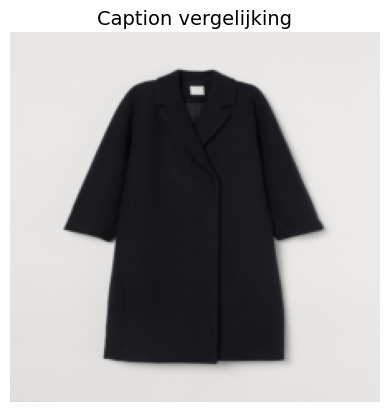

Model-caption    : solid black short straight-cut coat in a soft wool blend with a collar concealed press-studs down the front and a detachable tie belt at the
Originele caption: solid black calf-length coat in woven fabric with notch lapels concealed press-studs down the front discreet pockets in the side seams and long slightly wider raglan sleeves lined


In [ ]:
# ChatGPT, 2025, Prompt 1: "Hoe wordt een afbeelding op inference-structuurniveau verwerkt door ViT naar tekst door GPT-2 binnen een encoder-decoder-architectuur? "
# ChatGPT, 2025, Prompt 2: "Hoe valideer ik de generalisatiecapaciteit van mijn model visueel en semantisch? Wat is het belang van directe vergelijking tussen modeloutput en referentiecaption, en hoe ondersteun ik die beoordeling kwalitatief naast metrische scores?"
# Link: https://chatgpt.com/share/6857ff63-c0b8-8001-8825-938ed388da3f

def generate_caption(image_pil):
    image_tensor = image_transform(image_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        generated_ids = model.generate(image_tensor, max_length=max_length)
    caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return caption

# Reset tijdelijk format om toegang te krijgen tot 'text'
val_dataset.reset_format()

# Random index
random_index = random.randint(0, len(val_dataset) - 1)
example = val_dataset[random_index]

true_caption = example["text"]

# Zet list -> tensor -> PIL
img_tensor = torch.tensor(example["pixel_values"])
img_pil = transforms.ToPILImage()(img_tensor)

# Genereer caption
generated_caption = generate_caption(img_pil)

# Toon afbeelding + resultaten
plt.imshow(img_pil)
plt.axis("off")
plt.title("Caption vergelijking", fontsize=14)
plt.show()

print(f"Model-caption    : {generated_caption}")
print(f"Originele caption: {true_caption}")

# Zet format terug voor training
val_dataset.set_format(type="torch", columns=["pixel_values", "labels"])

## Samenvatting van gekozen instellingen en onderbouwing

| Hyperparameter / Instelling     | Gekozen waarde     | Onderbouwing                                                                                                   |
|----------------------------------|---------------------|------------------------------------------------------------------------------------------------------------------|
| **max_length**                   | 32                  | Captions in de dataset zijn gemiddeld 10–20 tokens lang. 32 biedt ruimte zonder overmatig padden. Gebaseerd op analyses van COCO-captionlengtes. |
| **batch_size**                  | 8                   | Te grote batches veroorzaken geheugenproblemen in Colab. 8 biedt balans tussen performance en stabiliteit.     |
| **learning_rate**               | 5e-5                | Kleine waarde voorkomt dat het voorgetrainde model zijn kennis verliest (catastrofaal vergeten). Aanbevolen voor transformer fine-tuning. |
| **num_epochs**                  | 3                   | Voldoende om op kleine subset convergence te bereiken zonder overfitting. Training is stabiel en efficiënt.     |
| **optimizer**                   | AdamW               | Werkt beter dan Adam in combinatie met weight decay (betere generalisatie). Gebaseerd op literatuur (Loshchilov & Hutter, 2019). |
| **model**                       | ViT-GPT2 (nlpconnect/vit-gpt2-image-captioning) | Pre-trained encoder-decoder model specifiek ontwikkeld voor image captioning. Werkt direct met beelden en genereert natuurlijke taal. |
| **dataset**                     | H&M Captions (Hugging Face) | Dataset bevat realistische productomschrijvingen voor mode. Perfect voor fine-tuning op beeld-bijschrift taken. |
| **eval-metriek**                | BLEU (1–4 gram)     | Standaardmaat voor automatische tekstgeneratie. Meet overlap tussen gegenereerde tekst en referentiecaption.   |
| **datasplitsing**              | 2000 training / 300 validatie | Om geheugenverbruik in Colab te beperken én het model toch effectief te trainen en valideren.                 |